# Demonstration of Full ML Pipeline with a Materials Science Database

We will use Matminer to fetch materials datasets that are ML-ready (i.e., they largely don't require any data cleaning step). We will then consider two featurization approaches: compositional (using Matminer again) and structural (using DScribe). Then we will remove low variance features and highly correlated features with Pandas. Lastly, we use Scikit-Learn for data splitting, recursive feature elimintation, model performance metrics calculations, and ML model training (random forest model).

In [1]:
pip install requests

Note: you may need to restart the kernel to use updated packages.


### filter for oxygen-containing compounds. The OQMD API does not support "or" logic, so I cant just filter for metal oxides

In [33]:
url = "http://oqmd.org/oqmdapi/formationenergy"

all_entries = []
limit = 50  # max entries per request allowed by OQMD
offset = 0
max_entries = 1000

while len(all_entries) < max_entries:
    params = {
        "filter": "element_set=(O)",
        "limit": limit,
        "offset": offset
    }

    r = requests.get(url, params=params)
    data = r.json()

    batch = data.get("data", [])
    if not batch:
        break

    all_entries.extend(batch)
    offset += limit

    if len(all_entries) >= max_entries:
        # Stop if we have enough data
        all_entries = all_entries[:max_entries]
        break

print(f"Total entries retrieved: {len(all_entries)}")

for entry in all_entries[:1000]:  # print entries
    print(entry.get("name"))

#for entry in all_entries[:10]:  # print first 10 as example
#    print(entry.get("volume"), entry.get("band_gap"))

Total entries retrieved: 1000
ZnO
CuO
TiO
VO
BeO
MgO
MnO
NiO
ZnO
AgO
NiO
FeO
ZnO
AlO
NiO
CaO
PdO
SrO
SrO
PaO
BaO
TaO
O
ScO
YbO
BeO
CdO
NbO
NpO
PdO
GdO
PuO
NiO
BiO
ZrO
PtO
FeO
UO
SnO2
O
PrO
SmO
ZrO2
CrO
PdO
K2O
SrO2
Li2O
O
UO2
BaO2
Na2O
PuO2
LiO2
PaO2
Al2O
SiO2
TbO2
BaO2
Ag2O
Rb2O
HgO
CSO
KO2
RbO2
Cs2O
NpO2
PtO2
CsO2
NiO2
PbO2
CsO
NaCuO2
LiO3
AlCuO2
RbNdO2
GaCuO2
RbSmO2
FeCuO2
RbGdO2
YbAgO2
LiNiO2
PbO
NaNiO2
NaFeO2
NaCuO2
KPrO2
RbDyO2
RbHoO2
ReO3
NaNO2
RbEuO2
PtO
UO3
RbLaO2
CrCuO2
CaO
CdO
FeAgO2
CuO
MgO
SrCdO2
CuAgO2
LiCrO2
NaAlO2
CaO2
MnCuO2
CaFeO2
RbErO2
RbTmO2
RbYbO2
RbLuO2
NaCrO2
CaHgO2
NiAgO2
LiMoO2
BaHgO2
NaInO2
LiVO2
RbScO2
NaErO2
VBr2O
LuAgO2
InCuO2
AgRhO2
PbO
CaCuO2
ZnO
NiHO2
SnO
NaMnO2
CrAgO2
Sr2SO
UO3
PdO
BeO
LiAlO2
BaO
SrFeO2
LiGaO2
O
CdHgO2
BaSrO2
BaCaO2
WO3
MgO
SrCaO2
YCuO2
LiRhO2
NdNiO2
NiHO2
BaO
CuO
CsIO3
NaTaO3
NaTlO2
NaVO2
CuO2
ScBiO3
BaIrO3
KCrO2
SrVO3
LaAlO3
NdAlO3
VCl2O
Na3ClO
NaVO2
RbTlO2
NaTaO3
Li3BrO
BaPaO3
PrAlO3
KTaO3
K3BrO
CaTiO3
SrNbO3
ZrTaNO
SrCrO3
HfPbO3
Ba

In [34]:
# CHECK COMPOSITION TO SEE IF IT CONTAINS OXYGEN
for entry in all_entries[:1000]:  # print entries
    print(entry.get("composition"))

O1 Zn1
Cu1 O1
O1 Ti1
O1 V1
Be1 O1
Mg1 O1
Mn1 O1
Ni1 O1
O1 Zn1
Ag1 O1
Ni1 O1
Fe1 O1
O1 Zn1
Al1 O1
Ni1 O1
Ca1 O1
O1 Pd1
O1 Sr1
O1 Sr1
O1 Pa1
Ba1 O1
O1 Ta1
O1
O1 Sc1
O1 Yb1
Be1 O1
Cd1 O1
Nb1 O1
Np1 O1
O1 Pd1
Gd1 O1
O1 Pu1
Ni1 O1
Bi1 O1
O1 Zr1
O1 Pt1
Fe1 O1
O1 U1
O2 Sn1
O1
O1 Pr1
O1 Sm1
O2 Zr1
Cr1 O1
O1 Pd1
K2 O1
O2 Sr1
Li2 O1
O1
O2 U1
Ba1 O2
Na2 O1
O2 Pu1
Li1 O2
O2 Pa1
Al2 O1
O2 Si1
O2 Tb1
Ba1 O2
Ag2 O1
O1 Rb2
Hg1 O1
C1 O1 S1
K1 O2
O2 Rb1
Cs2 O1
Np1 O2
O2 Pt1
Cs1 O2
Ni1 O2
O2 Pb1
Cs1 O1
Cu1 Na1 O2
Li1 O3
Al1 Cu1 O2
Nd1 O2 Rb1
Cu1 Ga1 O2
O2 Rb1 Sm1
Cu1 Fe1 O2
Gd1 O2 Rb1
Ag1 O2 Yb1
Li1 Ni1 O2
O1 Pb1
Na1 Ni1 O2
Fe1 Na1 O2
Cu1 Na1 O2
K1 O2 Pr1
Dy1 O2 Rb1
Ho1 O2 Rb1
O3 Re1
N1 Na1 O2
Eu1 O2 Rb1
O1 Pt1
O3 U1
La1 O2 Rb1
Cr1 Cu1 O2
Ca1 O1
Cd1 O1
Ag1 Fe1 O2
Cu1 O1
Mg1 O1
Cd1 O2 Sr1
Ag1 Cu1 O2
Cr1 Li1 O2
Al1 Na1 O2
Ca1 O2
Cu1 Mn1 O2
Ca1 Fe1 O2
Er1 O2 Rb1
O2 Rb1 Tm1
O2 Rb1 Yb1
Lu1 O2 Rb1
Cr1 Na1 O2
Ca1 Hg1 O2
Ag1 Ni1 O2
Li1 Mo1 O2
Ba1 Hg1 O2
In1 Na1 O2
Li1 O2 V1
O2 Rb1 Sc1
Er1 Na1 O2
Br2 O1 V1
Ag1 Lu

In [35]:
#EXPORT TO PANDAS DATAFRAME
import pandas as pd

#records = data["all_entries"]
df = pd.DataFrame(all_entries)
print(df.head())

  name  entry_id  calculation_id  icsd_id  formationenergy_id  \
0  ZnO     20684            4500   163382             4061643   
1  CuO     11469            4561    61323             4061682   
2  TiO     17898            4752   105551             4061754   
3   VO      5578            5023    28681             4061871   
4  BeO     20737            5038   163820             4061895   

   duplicate_entry_id composition composition_generic prototype spacegroup  \
0              117131      O1 Zn1                  AB      CsCl      Pm-3m   
1               11469      Cu1 O1                  AB      NaCl      Fm-3m   
2               17898      O1 Ti1                  AB      NaCl      Fm-3m   
3                5578       O1 V1                  AB      NaCl      Fm-3m   
4               20737      Be1 O1                  AB  ZnS(cF8)      F-43m   

    volume  ntypes  natoms                                          unit_cell  \
0  18.8294       2       2  [[2.66039, 0.0, 0.0], [0.0, 2.6

### Use Pymatgen to further filter for metal-containing compounds

In [36]:
# FILTER FOR METAL OXIDES, SINCE ORIGINAL QUERY IS ALL OXYGEN-CONTAINING COMPOUNDS
from pymatgen.core import Composition
from pymatgen.core.periodic_table import Element
import pandas as pd

# assume your dataframe is called df and has a column called "composition" 
# that contains chemical formulas like "Fe2O3", "Al2O3", "TiO2", etc.

def has_metal_and_oxygen(formula):
    comp = Composition(formula)

    # Check if any element is a metal
    for el in comp.elements:
        if Element(el).is_metal:
            return True

    return False

# Filter the dataframe
df_oxides = df[df["composition"].apply(has_metal_and_oxygen)].reset_index(drop=True)

print(df_oxides.head())
print("Number of metal oxides:", len(df_oxides))


  name  entry_id  calculation_id  icsd_id  formationenergy_id  \
0  ZnO     20684            4500   163382             4061643   
1  CuO     11469            4561    61323             4061682   
2  TiO     17898            4752   105551             4061754   
3   VO      5578            5023    28681             4061871   
4  BeO     20737            5038   163820             4061895   

   duplicate_entry_id composition composition_generic prototype spacegroup  \
0              117131      O1 Zn1                  AB      CsCl      Pm-3m   
1               11469      Cu1 O1                  AB      NaCl      Fm-3m   
2               17898      O1 Ti1                  AB      NaCl      Fm-3m   
3                5578       O1 V1                  AB      NaCl      Fm-3m   
4               20737      Be1 O1                  AB  ZnS(cF8)      F-43m   

    volume  ntypes  natoms                                          unit_cell  \
0  18.8294       2       2  [[2.66039, 0.0, 0.0], [0.0, 2.6

### Now I have a dataset of compounds that contain oxygen and 1 or more metal ions - **Metal Oxides!**

In [112]:
df_oxides.head()

,name,entry_id,calculation_id,icsd_id,formationenergy_id,duplicate_entry_id,composition,composition_generic,prototype,spacegroup,volume,ntypes,natoms,unit_cell,sites,band_gap,delta_e,stability,fit,calculation_label
0,ZnO,20684,4500,163382,4061643,117131,O1 Zn1,AB,CsCl,Pm-3m,18.8294,2,2,"[[2.66039, 0.0, 0.0], [0.0, 2.66039, 0.0], [0....","[O @ 0.5 0.5 0.5, Zn @ 0 0 0]",0.000,-0.932217,0.717532,standard,static
1,CuO,11469,4561,61323,4061682,11469,Cu1 O1,AB,NaCl,Fm-3m,18.2857,2,2,"[[2.091032, -2.091032, 0.0], [-2.091032, 0.0, ...","[Cu @ 0 0 0, O @ 0.5 0 0.5]",0.000,-0.673436,0.158098,standard,static
2,TiO,17898,4752,105551,4061754,17898,O1 Ti1,AB,NaCl,Fm-3m,19.2139,2,2,"[[2.125829, -2.125829, 0.0], [-2.125829, 0.0, ...","[O @ 0.5 0 0.5, Ti @ 0 0 0]",0.000,-2.522310,0.259050,standard,static
3,VO,5578,5023,28681,4061871,5578,O1 V1,AB,NaCl,Fm-3m,21.6233,2,2,"[[2.211215, -2.211215, 0.0], [-2.211215, 0.0, ...","[O @ 0.5 0 0.5, V @ 0 0 0]",1.191,-2.259973,0.002871,standard,static
4,BeO,20737,5038,163820,4061895,20737,Be1 O1,AB,ZnS(cF8),F-43m,13.7009,2,2,"[[1.899211, -1.899211, 0.0], [-1.899211, 0.0, ...","[Be @ 0 0 0, O @ 0.75 0.5 0.25]",7.021,-2.960379,0.005831,standard,static


In [37]:
df_oxides.describe()

,entry_id,calculation_id,icsd_id,formationenergy_id,duplicate_entry_id,volume,ntypes,natoms,band_gap,delta_e,stability
count,969.000000,969.000000,969.000000,9.690000e+02,969.000000,969.000000,969.000000,969.000000,969.000000,969.000000,969.000000
mean,12171.840041,27159.156863,99807.673891,4.075788e+06,21371.417957,121.419337,3.045408,8.399381,1.865229,-2.100730,0.094227
std,7808.199905,17240.435323,114763.642938,6.495229e+03,68093.285996,102.949085,0.684843,8.722799,1.745847,0.891382,0.263651
min,1609.000000,4500.000000,22.000000,4.061643e+06,1609.000000,11.803000,2.000000,2.000000,0.000000,-4.150927,0.000000
25%,5247.000000,14448.000000,27118.000000,4.070235e+06,5505.000000,65.141200,3.000000,5.000000,0.000000,-2.796630,0.000000
50%,11524.000000,21429.000000,61683.000000,4.077213e+06,12538.000000,96.047200,3.000000,6.000000,1.594000,-2.156176,0.011308
75%,19563.000000,33896.000000,152123.000000,4.081419e+06,20527.000000,139.276000,3.000000,8.000000,3.091000,-1.474218,0.064340
max,31135.000000,76996.000000,653737.000000,4.085928e+06,661940.000000,850.377000,6.000000,80.000000,8.496000,2.159833,2.975383


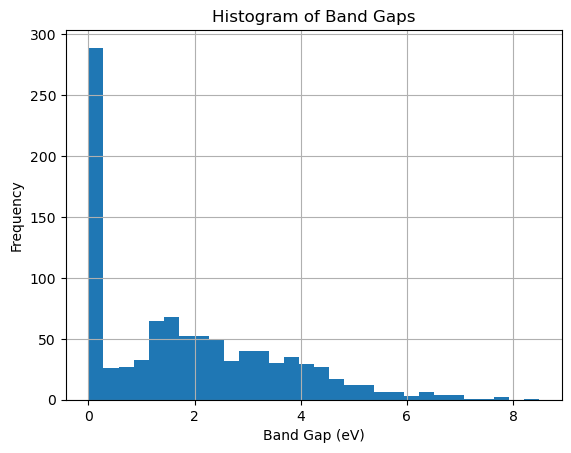

In [58]:
import matplotlib.pyplot as plt

df_oxides['band_gap'].hist(bins=30)
plt.xlabel('Band Gap (eV)')
plt.ylabel('Frequency')
plt.title('Histogram of Band Gaps')
plt.show()

In [59]:
# copy dataframe
df_comp = df_oxides.copy()
df_comp.describe()

,entry_id,calculation_id,icsd_id,formationenergy_id,duplicate_entry_id,volume,ntypes,natoms,band_gap,delta_e,stability
count,969.000000,969.000000,969.000000,9.690000e+02,969.000000,969.000000,969.000000,969.000000,969.000000,969.000000,969.000000
mean,12171.840041,27159.156863,99807.673891,4.075788e+06,21371.417957,121.419337,3.045408,8.399381,1.865229,-2.100730,0.094227
std,7808.199905,17240.435323,114763.642938,6.495229e+03,68093.285996,102.949085,0.684843,8.722799,1.745847,0.891382,0.263651
min,1609.000000,4500.000000,22.000000,4.061643e+06,1609.000000,11.803000,2.000000,2.000000,0.000000,-4.150927,0.000000
25%,5247.000000,14448.000000,27118.000000,4.070235e+06,5505.000000,65.141200,3.000000,5.000000,0.000000,-2.796630,0.000000
50%,11524.000000,21429.000000,61683.000000,4.077213e+06,12538.000000,96.047200,3.000000,6.000000,1.594000,-2.156176,0.011308
75%,19563.000000,33896.000000,152123.000000,4.081419e+06,20527.000000,139.276000,3.000000,8.000000,3.091000,-1.474218,0.064340
max,31135.000000,76996.000000,653737.000000,4.085928e+06,661940.000000,850.377000,6.000000,80.000000,8.496000,2.159833,2.975383


### **Featurization**: OQMD uses strings to identify compisition, so we must convert them to a valid pymatgen composition. Then we weill featurize the compositions using the Matminer *ElementProperty* featurizer and use the magpie preset.

In [82]:
from pymatgen.core import Composition

df_comp["composition"] = df_comp["composition"].apply(Composition)

In [83]:
from matminer.featurizers.composition.composite import ElementProperty

el_prop_featuriser = ElementProperty.from_preset(preset_name='magpie', impute_nan=False)
el_prop_featuriser.set_n_jobs(1)
df_featurized = el_prop_featuriser.featurize_dataframe(df_comp, col_id='composition', ignore_errors=True) #SET IGNORE_ERRORS=TRUE, THIS MAY BE A MISTAKE

print(df_featurized.shape)  # type: ignore
print(df_featurized.isnull().sum().sum())  # Check for any NaN values  # type: ignore
#df_featurized.head()  # type: ignore
df_featurized.describe()  # type: ignore

/Users/coenradttaylor/opt/anaconda3/envs/chme6320/lib/python3.11/site-packages/matminer/utils/data.py:326: UserWarning: MagpieData(impute_nan=False):
In a future release, impute_nan will be set to True by default.
                    This means that features that are missing or are NaNs for elements
                    from the data source will be replaced by the average of that value
                    over the available elements.
                    This avoids NaNs after featurization that are often replaced by
                    dataset-dependent averages.
  warnings.warn(f"{self.__class__.__name__}(impute_nan=False):\n" + IMPUTE_NAN_WARNING)


ElementProperty:   0%|          | 0/969 [00:00<?, ?it/s]

(969, 152)
153


,entry_id,calculation_id,icsd_id,formationenergy_id,duplicate_entry_id,volume,ntypes,natoms,band_gap,delta_e,...,MagpieData range GSmagmom,MagpieData mean GSmagmom,MagpieData avg_dev GSmagmom,MagpieData mode GSmagmom,MagpieData minimum SpaceGroupNumber,MagpieData maximum SpaceGroupNumber,MagpieData range SpaceGroupNumber,MagpieData mean SpaceGroupNumber,MagpieData avg_dev SpaceGroupNumber,MagpieData mode SpaceGroupNumber
count,969.000000,969.000000,969.000000,9.690000e+02,969.000000,969.000000,969.000000,969.000000,969.000000,969.000000,...,969.000000,969.000000,969.000000,969.000000,969.000000,969.000000,969.000000,969.000000,969.000000,969.000000
mean,12171.840041,27159.156863,99807.673891,4.075788e+06,21371.417957,121.419337,3.045408,8.399381,1.865229,-2.100730,...,0.175184,0.042694,0.061779,0.000001,11.712074,212.788442,201.076367,101.011418,85.064827,28.637771
std,7808.199905,17240.435323,114763.642938,6.495229e+03,68093.285996,102.949085,0.684843,8.722799,1.745847,0.891382,...,0.538180,0.139743,0.196175,0.000020,1.647898,33.766450,33.789430,32.687819,21.099564,56.107297
min,1609.000000,4500.000000,22.000000,4.061643e+06,1609.000000,11.803000,2.000000,2.000000,0.000000,-4.150927,...,0.000000,0.000000,0.000000,0.000000,2.000000,12.000000,0.000000,11.500000,0.000000,2.000000
25%,5247.000000,14448.000000,27118.000000,4.070235e+06,5505.000000,65.141200,3.000000,5.000000,0.000000,-2.796630,...,0.000000,0.000000,0.000000,0.000000,12.000000,194.000000,182.000000,84.333333,73.920000,12.000000
50%,11524.000000,21429.000000,61683.000000,4.077213e+06,12538.000000,96.047200,3.000000,6.000000,1.594000,-2.156176,...,0.000000,0.000000,0.000000,0.000000,12.000000,225.000000,213.000000,100.500000,91.259259,12.000000
75%,19563.000000,33896.000000,152123.000000,4.081419e+06,20527.000000,139.276000,3.000000,8.000000,3.091000,-1.474218,...,0.000000,0.000000,0.000000,0.000000,12.000000,229.000000,217.000000,119.500000,99.750000,12.000000
max,31135.000000,76996.000000,653737.000000,4.085928e+06,661940.000000,850.377000,6.000000,80.000000,8.496000,2.159833,...,2.110663,1.055331,1.055331,0.000310,12.000000,229.000000,227.000000,201.333333,109.000000,229.000000


Number of features before cleaning: 150
Columns with very small variance: ['MagpieData maximum NsValence', 'MagpieData minimum NdValence', 'MagpieData minimum NfValence', 'MagpieData minimum NsUnfilled', 'MagpieData minimum NdUnfilled', 'MagpieData minimum NfUnfilled', 'MagpieData minimum GSbandgap', 'MagpieData minimum GSmagmom', 'MagpieData mode GSmagmom']
Number of features after removing small variance columns: 133
Columns to drop due to high correlation: {'MagpieData range Column', 'MagpieData maximum NdValence', 'MagpieData range NdValence', 'MagpieData range NfUnfilled', 'MagpieData avg_dev Number', 'MagpieData range GSbandgap', 'MagpieData maximum NpValence', 'MagpieData range SpaceGroupNumber', 'MagpieData range NsUnfilled', 'MagpieData mode Number', 'MagpieData range GSmagmom', 'MagpieData minimum AtomicWeight', 'MagpieData maximum NfValence', 'MagpieData range MendeleevNumber', 'MagpieData maximum SpaceGroupNumber', 'MagpieData minimum MendeleevNumber', 'MagpieData maximum A

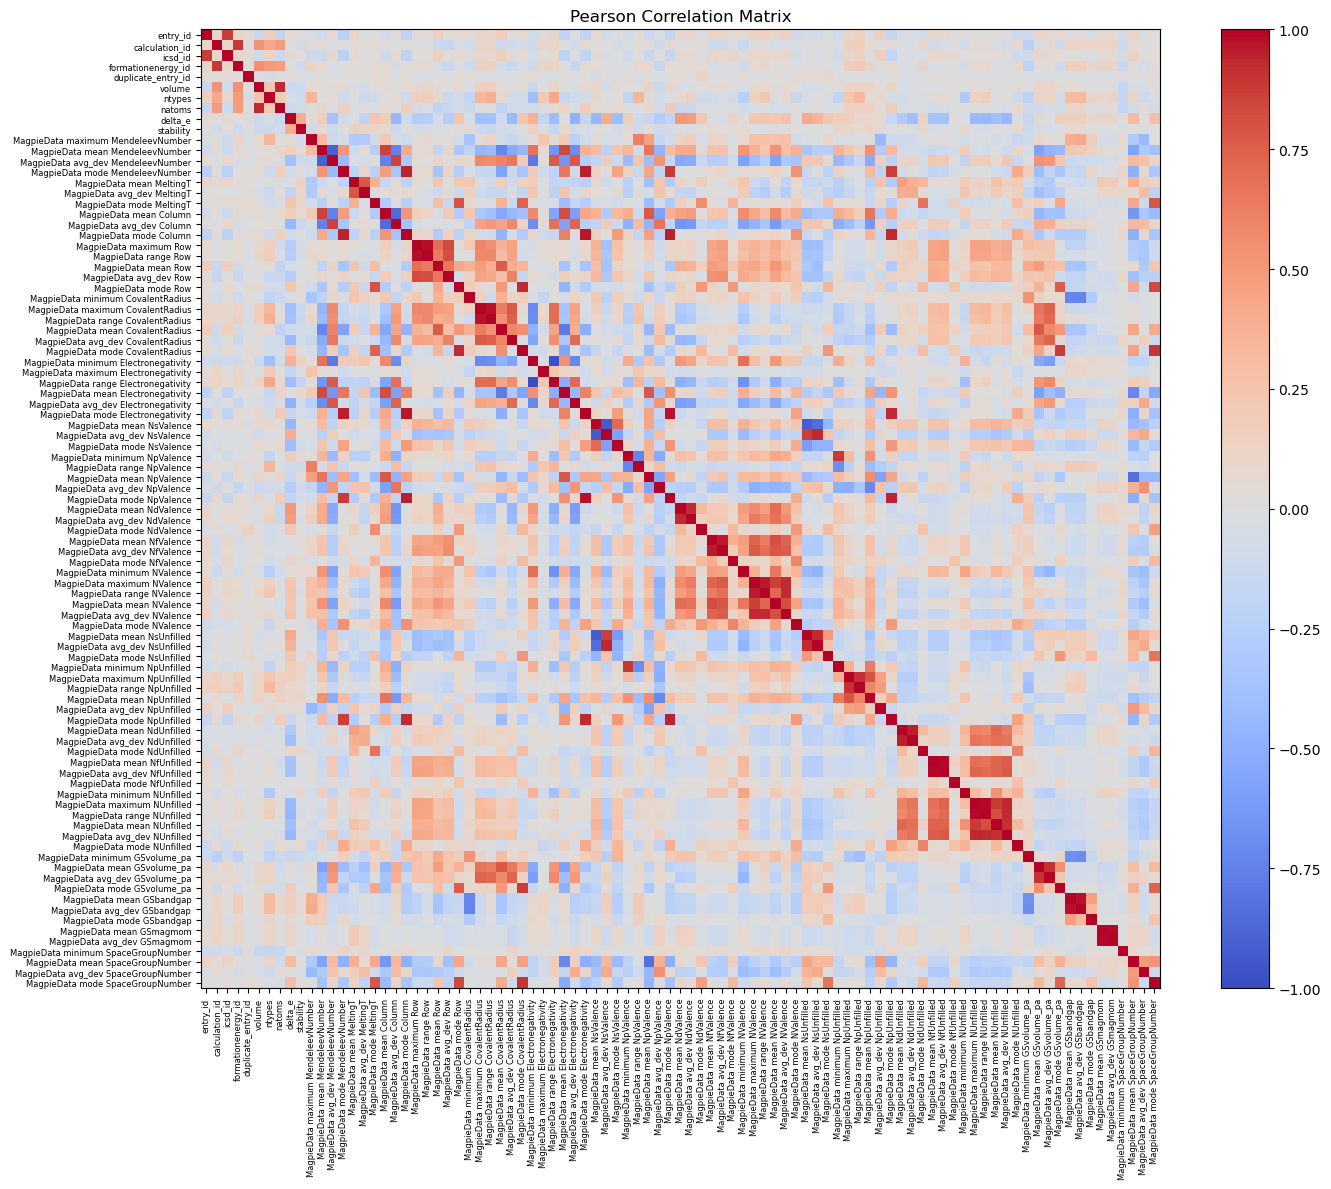

In [ ]:
y = df_featurized['band_gap']  # type: ignore
X_all = df_featurized.drop(columns=['band_gap', 'composition']) # type: ignore

print("Number of features before cleaning:", X_all.shape[1])

# Keep ONLY numeric columns
X_all = X_all.select_dtypes(include=['number'])

# Identify columns with very small variance and drop them
small_var_cols = X_all.columns[X_all.var() < 1e-5].tolist()
print("Columns with very small variance:", small_var_cols)
X_all = X_all.drop(columns=small_var_cols)
corr_matrix = X_all.corr(method='pearson')
print("Number of features after removing small variance columns:", X_all.shape[1])

# Remove highly correlated columns
threshold = 0.98 #SET IT TO 0.98, COULD SWITCH IT BACK TO 0.99 IF NEEDED
to_drop = set()
for col in corr_matrix.columns:
    high_corr = corr_matrix.index[(corr_matrix[col].abs() > threshold) & (corr_matrix.index != col)]
    to_drop.update(high_corr)
print("Columns to drop due to high correlation:", to_drop)
X = X_all.drop(columns=list(to_drop))
print("Number of features after removing highly correlated columns:", X.shape[1])

# For the remaining features, let's visualize the correlation matrix
corr_matrix = X.corr(method='pearson')

plt.figure(figsize=(16, 12))
im = plt.imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title('Pearson Correlation Matrix')
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90, fontsize=6)
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns, fontsize=6)
plt.tight_layout()
plt.show()

### scale and split train/test

In [88]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

test_fraction = 0.1
validation_fraction = 0.2
X_trainval, X_test, y_trainval, y_test = train_test_split(X_scaled, y, 
                                                          test_size=test_fraction, 
                                                          random_state=17)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, 
                                                  test_size=validation_fraction/(1-test_fraction), 
                                                  random_state=17)
print(f"Training fraction: {X_train.shape[0] / X_scaled.shape[0]:.2f}")
print(f"Validation fraction: {X_val.shape[0] / X_scaled.shape[0]:.2f}")
print(f"Test fraction: {X_test.shape[0] / X_scaled.shape[0]:.2f}")



Training fraction: 0.70
Validation fraction: 0.20
Test fraction: 0.10


### Dummy model for baseline prediction

In [91]:
from sklearn.metrics import mean_absolute_error

mean_train = y_train.mean()
baseline_mae = mean_absolute_error(y_val, [mean_train] * len(y_val))
print(f"Baseline MAE (predicting band gap): {baseline_mae:.4f} eV")

Baseline MAE (predicting band gap): 1.3480 eV


### **Hyperparameter optimization** Picking two values each for n_estimators, max_depth, max_features, and min_samples_split (omitting min_samples_leaf, bootstrap, criterion, due to computation time), for a total of 16 models. Will select best combination of hyperparameters

In [93]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from itertools import product
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

# SELECTION OF HYPERPARAMETERS
param_grid = {
    "n_estimators": [100, 500],
    "max_depth": [None, 20],
    "max_features": ["sqrt", 0.5],
    "min_samples_split": [2, 10],
}

# Generate all combinations
param_combinations = list(product(
    param_grid["n_estimators"],
    param_grid["max_depth"],
    param_grid["max_features"],
    param_grid["min_samples_split"]
))
results = []

#Train each model
for (n_est, depth, max_feat, min_split) in tqdm(param_combinations, desc="Training 16 RF models"):
    
    rf = RandomForestRegressor(
        n_estimators=n_est,
        max_depth=depth,
        max_features=max_feat,
        min_samples_split=min_split,
        random_state=17,
        n_jobs=-1
    )
    
    rf.fit(X_train, y_train)
    y_train_pred = rf.predict(X_train)
    y_val_pred = rf.predict(X_val)

    train_mae = mean_absolute_error(y_train, y_train_pred)
    val_mae = mean_absolute_error(y_val, y_val_pred)

    results.append({
        "n_estimators": n_est,
        "max_depth": depth,
        "max_features": max_feat,
        "min_samples_split": min_split,
        "train_mae": train_mae,
        "val_mae": val_mae
    })

import pandas as pd
results_df = pd.DataFrame(results)

#pick lowest MAE
best_row = results_df.loc[results_df["val_mae"].idxmin()]
print("Best Hyperparameters:")
print(best_row)

print("\nBest Validation MAE:", best_row["val_mae"])

# Show full table sorted by validation performance
display(results_df.sort_values("val_mae"))


Training 16 RF models:   0%|          | 0/16 [00:00<?, ?it/s]

Best Hyperparameters:
n_estimators              500
max_depth                20.0
max_features              0.5
min_samples_split           2
train_mae             0.22842
val_mae              0.605254
Name: 14, dtype: object

Best Validation MAE: 0.6052542807280236


,n_estimators,max_depth,max_features,min_samples_split,train_mae,val_mae
14,500,20.0,0.5,2,0.228420,0.605254
10,500,NaN,0.5,2,0.228754,0.607630
6,100,20.0,0.5,2,0.231985,0.615436
2,100,NaN,0.5,2,0.232992,0.619873
15,500,20.0,0.5,10,0.341879,0.645777
11,500,NaN,0.5,10,0.341867,0.646043
7,100,20.0,0.5,10,0.345773,0.653929
3,100,NaN,0.5,10,0.345773,0.653929
4,100,20.0,sqrt,2,0.249953,0.669237
12,500,20.0,sqrt,2,0.246159,0.671473


### **Recursive feature elimination**

RFE Progress:   0%|          | 0/18 [00:00<?, ?it/s]

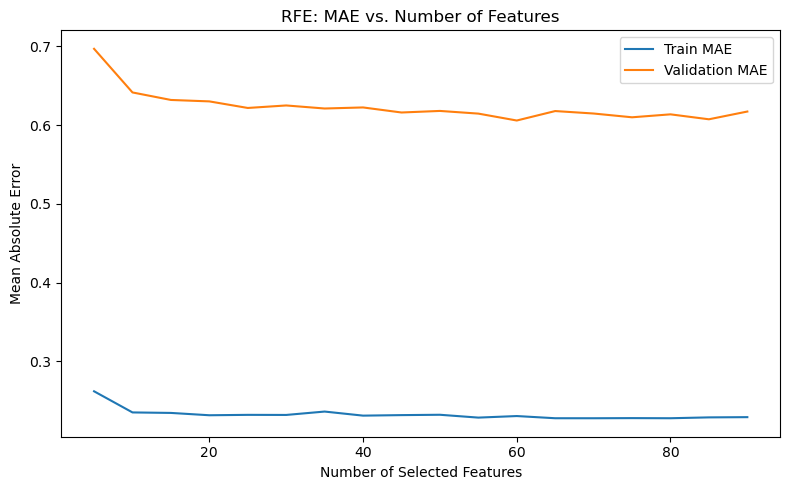

In [94]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_absolute_error
from tqdm.notebook import tqdm

rf = RandomForestRegressor(n_estimators=500, max_depth=20, max_features=0.5, min_samples_split=2, random_state=17, n_jobs=1)
n_features_list = list(range(5, X_val.shape[1]+1, 5))
val_errors = []
train_errors = []
selected_features_dict = {}

for n_features in tqdm(n_features_list, desc='RFE Progress'):
    rfe = RFE(estimator=rf, n_features_to_select=n_features, step=5)
    rfe.fit(X_train, y_train)
    selected_features_dict[n_features] = list(X.columns[rfe.support_])
    X_train_rfe = rfe.transform(X_train)
    rf.fit(X_train_rfe, y_train)
    y_train_pred = rf.predict(X_train_rfe)
    train_errors.append(mean_absolute_error(y_train, y_train_pred))
    X_val_rfe = rfe.transform(X_val)
    y_val_pred = rf.predict(X_val_rfe)
    val_errors.append(mean_absolute_error(y_val, y_val_pred))

plt.figure(figsize=(8, 5))
plt.plot(n_features_list, train_errors, label='Train MAE')
plt.plot(n_features_list, val_errors, label='Validation MAE')
plt.xlabel('Number of Selected Features')
plt.ylabel('Mean Absolute Error')
plt.title('RFE: MAE vs. Number of Features')
plt.legend()
plt.tight_layout()
plt.show()

### **Final model evalutation**: only need ~15 features to minimize MAE

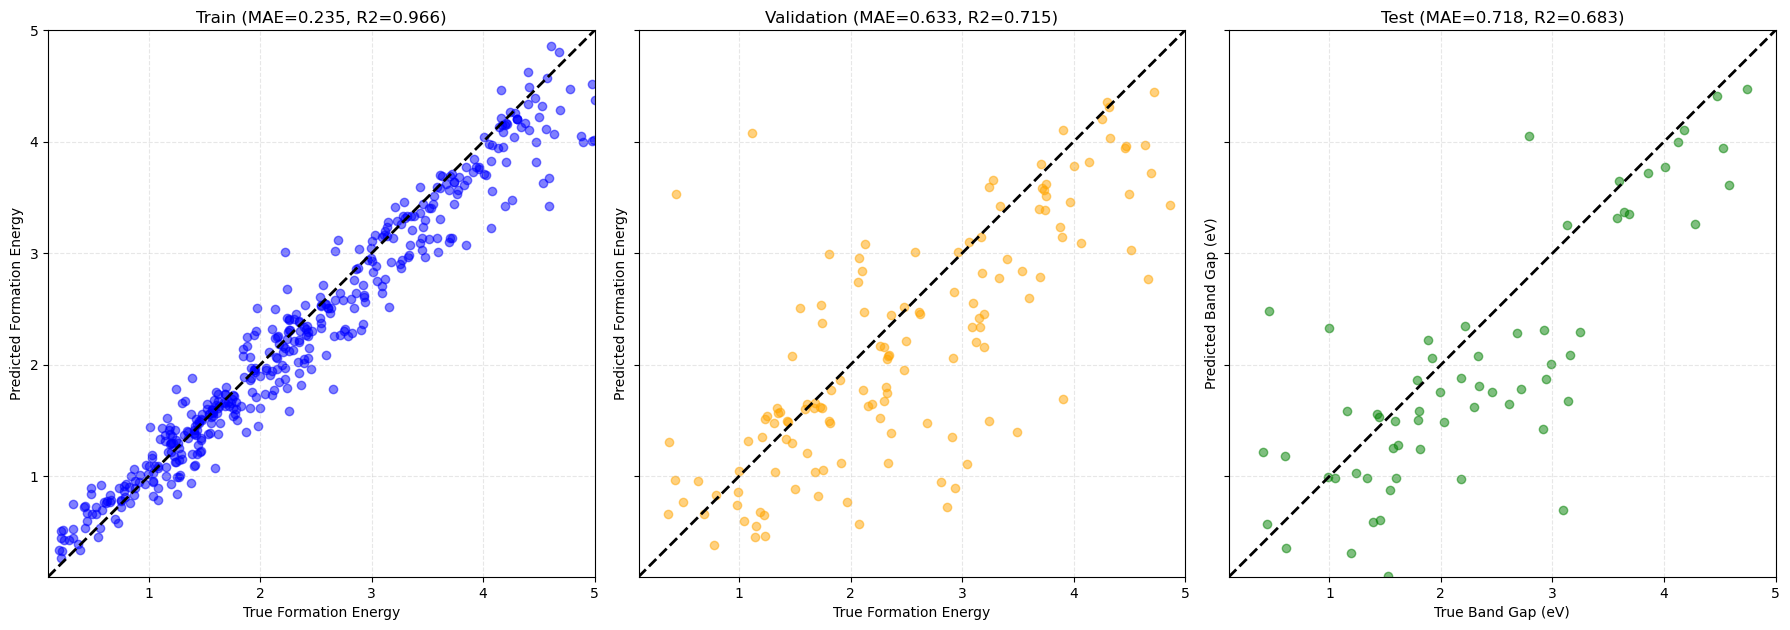

In [106]:
from sklearn.metrics import r2_score

final_features = selected_features_dict[15]
rf_final = RandomForestRegressor(
    n_estimators=500,
    max_depth=20,
    max_features=0.5,
    min_samples_split=2,
    random_state=1,
    n_jobs=1
)

X_train_final = X_train[:, [X.columns.get_loc(f) for f in final_features]]
rf_final.fit(X_train_final, y_train)

# Predict
X_val_final = X_val[:, [X.columns.get_loc(f) for f in final_features]]
X_test_final = X_test[:, [X.columns.get_loc(f) for f in final_features]]

y_train_pred = rf_final.predict(X_train_final)
y_val_pred = rf_final.predict(X_val_final)
y_test_pred = rf_final.predict(X_test_final)

# Metrics
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_val = mean_absolute_error(y_val, y_val_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

r2_train = r2_score(y_train, y_train_pred)
r2_val = r2_score(y_val, y_val_pred)
r2_test = r2_score(y_test, y_test_pred)

# --- Parity plots (0.1 to 5 range) ---
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)

min_val = 0.1
max_val = 5.0

# Train
axes[0].scatter(y_train, y_train_pred, alpha=0.5, color='blue')
axes[0].plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)
axes[0].set_xlim(min_val, max_val)
axes[0].set_ylim(min_val, max_val)
axes[0].set_title(f"Train (MAE={mae_train:.3f}, R2={r2_train:.3f})")
axes[0].set_xlabel("True Formation Energy")
axes[0].set_ylabel("Predicted Formation Energy")
axes[0].set_aspect('equal', adjustable='box')
axes[0].grid(True, linestyle='--', alpha=0.3)

# Validation
axes[1].scatter(y_val, y_val_pred, alpha=0.5, color='orange')
axes[1].plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)
axes[1].set_xlim(min_val, max_val)
axes[1].set_ylim(min_val, max_val)
axes[1].set_title(f"Validation (MAE={mae_val:.3f}, R2={r2_val:.3f})")
axes[1].set_xlabel("True Formation Energy")
axes[1].set_ylabel("Predicted Formation Energy")
axes[1].set_aspect('equal', adjustable='box')
axes[1].grid(True, linestyle='--', alpha=0.3)

# Test
axes[2].scatter(y_test, y_test_pred, alpha=0.5, color='green')
axes[2].plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)
axes[2].set_xlim(min_val, max_val)
axes[2].set_ylim(min_val, max_val)
axes[2].set_title(f"Test (MAE={mae_test:.3f}, R2={r2_test:.3f})")
axes[2].set_xlabel("True Band Gap (eV)")
axes[2].set_ylabel("Predicted Band Gap (eV)")
axes[2].set_aspect('equal', adjustable='box')
axes[2].grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()


# Attempt 2: Different featurizer

In [109]:
from dscribe.descriptors import CoulombMatrix
from ase.build import molecule
from ase.visualize import view
from dscribe.descriptors import EwaldSumMatrix
from pymatgen.io.ase import AseAtomsAdaptor

In [117]:
df_comp1 = df_oxides.copy()
df_comp1.head()

,name,entry_id,calculation_id,icsd_id,formationenergy_id,duplicate_entry_id,composition,composition_generic,prototype,spacegroup,volume,ntypes,natoms,unit_cell,sites,band_gap,delta_e,stability,fit,calculation_label
0,ZnO,20684,4500,163382,4061643,117131,O1 Zn1,AB,CsCl,Pm-3m,18.8294,2,2,"[[2.66039, 0.0, 0.0], [0.0, 2.66039, 0.0], [0....","[O @ 0.5 0.5 0.5, Zn @ 0 0 0]",0.000,-0.932217,0.717532,standard,static
1,CuO,11469,4561,61323,4061682,11469,Cu1 O1,AB,NaCl,Fm-3m,18.2857,2,2,"[[2.091032, -2.091032, 0.0], [-2.091032, 0.0, ...","[Cu @ 0 0 0, O @ 0.5 0 0.5]",0.000,-0.673436,0.158098,standard,static
2,TiO,17898,4752,105551,4061754,17898,O1 Ti1,AB,NaCl,Fm-3m,19.2139,2,2,"[[2.125829, -2.125829, 0.0], [-2.125829, 0.0, ...","[O @ 0.5 0 0.5, Ti @ 0 0 0]",0.000,-2.522310,0.259050,standard,static
3,VO,5578,5023,28681,4061871,5578,O1 V1,AB,NaCl,Fm-3m,21.6233,2,2,"[[2.211215, -2.211215, 0.0], [-2.211215, 0.0, ...","[O @ 0.5 0 0.5, V @ 0 0 0]",1.191,-2.259973,0.002871,standard,static
4,BeO,20737,5038,163820,4061895,20737,Be1 O1,AB,ZnS(cF8),F-43m,13.7009,2,2,"[[1.899211, -1.899211, 0.0], [-1.899211, 0.0, ...","[Be @ 0 0 0, O @ 0.75 0.5 0.25]",7.021,-2.960379,0.005831,standard,static


In [125]:
from pymatgen.core import Lattice, Structure

def parse_site(site_str):
    # Example input: "O @ 0.5 0.5 0.5"
    element, _, coords_str = site_str.partition(" @ ")
    coords = list(map(float, coords_str.split()))
    return element, coords

def create_structure(row):
    lattice = Lattice(row['unit_cell'])
    
    species = []
    coords = []
    
    for site_str in row['sites']:
        el, crd = parse_site(site_str)
        species.append(el)
        coords.append(crd)
    
    struct = Structure(lattice, species, coords)  # coords are fractional by default
    return struct

# Apply to your dataframe
df_comp1['structure'] = df_comp1.apply(create_structure, axis=1)

# Then make a copy with all existing columns + 'structure'
df_structure = df_comp1.copy()

df_structure.head()

,name,entry_id,calculation_id,icsd_id,formationenergy_id,duplicate_entry_id,composition,composition_generic,prototype,spacegroup,...,ntypes,natoms,unit_cell,sites,band_gap,delta_e,stability,fit,calculation_label,structure
0,ZnO,20684,4500,163382,4061643,117131,O1 Zn1,AB,CsCl,Pm-3m,...,2,2,"[[2.66039, 0.0, 0.0], [0.0, 2.66039, 0.0], [0....","[O @ 0.5 0.5 0.5, Zn @ 0 0 0]",0.000,-0.932217,0.717532,standard,static,"[[1.330195 1.330195 1.330195] O, [0. 0. 0.] Zn]"
1,CuO,11469,4561,61323,4061682,11469,Cu1 O1,AB,NaCl,Fm-3m,...,2,2,"[[2.091032, -2.091032, 0.0], [-2.091032, 0.0, ...","[Cu @ 0 0 0, O @ 0.5 0 0.5]",0.000,-0.673436,0.158098,standard,static,"[[0. 0. 0.] Cu, [2.091032 0. 0. ] O]"
2,TiO,17898,4752,105551,4061754,17898,O1 Ti1,AB,NaCl,Fm-3m,...,2,2,"[[2.125829, -2.125829, 0.0], [-2.125829, 0.0, ...","[O @ 0.5 0 0.5, Ti @ 0 0 0]",0.000,-2.522310,0.259050,standard,static,"[[2.125829 0. 0. ] O, [0. 0. 0.] Ti]"
3,VO,5578,5023,28681,4061871,5578,O1 V1,AB,NaCl,Fm-3m,...,2,2,"[[2.211215, -2.211215, 0.0], [-2.211215, 0.0, ...","[O @ 0.5 0 0.5, V @ 0 0 0]",1.191,-2.259973,0.002871,standard,static,"[[2.211215 0. 0. ] O, [0. 0. 0.] V]"
4,BeO,20737,5038,163820,4061895,20737,Be1 O1,AB,ZnS(cF8),F-43m,...,2,2,"[[1.899211, -1.899211, 0.0], [-1.899211, 0.0, ...","[Be @ 0 0 0, O @ 0.75 0.5 0.25]",7.021,-2.960379,0.005831,standard,static,"[[0. 0. 0.] Be, [ 0.9496055 -0.9496055 -0.9496..."


In [126]:
df_structure.describe()

,entry_id,calculation_id,icsd_id,formationenergy_id,duplicate_entry_id,volume,ntypes,natoms,band_gap,delta_e,stability
count,969.000000,969.000000,969.000000,9.690000e+02,969.000000,969.000000,969.000000,969.000000,969.000000,969.000000,969.000000
mean,12171.840041,27159.156863,99807.673891,4.075788e+06,21371.417957,121.419337,3.045408,8.399381,1.865229,-2.100730,0.094227
std,7808.199905,17240.435323,114763.642938,6.495229e+03,68093.285996,102.949085,0.684843,8.722799,1.745847,0.891382,0.263651
min,1609.000000,4500.000000,22.000000,4.061643e+06,1609.000000,11.803000,2.000000,2.000000,0.000000,-4.150927,0.000000
25%,5247.000000,14448.000000,27118.000000,4.070235e+06,5505.000000,65.141200,3.000000,5.000000,0.000000,-2.796630,0.000000
50%,11524.000000,21429.000000,61683.000000,4.077213e+06,12538.000000,96.047200,3.000000,6.000000,1.594000,-2.156176,0.011308
75%,19563.000000,33896.000000,152123.000000,4.081419e+06,20527.000000,139.276000,3.000000,8.000000,3.091000,-1.474218,0.064340
max,31135.000000,76996.000000,653737.000000,4.085928e+06,661940.000000,850.377000,6.000000,80.000000,8.496000,2.159833,2.975383


In [127]:
# -------------featurization -------------

from dscribe.descriptors import EwaldSumMatrix
from pymatgen.io.ase import AseAtomsAdaptor
import numpy as np

# Determine the maximum number of atoms across all structures in the dataset
n_max = 0
for mat in df_structure['structure']:
    if len(mat) > n_max :
        n_max = len(mat)
print(n_max)

ews = EwaldSumMatrix(n_atoms_max=n_max, permutation="eigenspectrum")

ase_structures = [AseAtomsAdaptor.get_atoms(struc) for struc in df_structure['structure']]
ews_matrices = np.array(ews.create(ase_structures))

80


In [131]:
ews_columns = [f'ews_{i}' for i in range(ews_matrices.shape[1])]
df_featurized_ews = df_structure.copy() #NEED TO COPY DF_STRUCTURE NOT MPIDS
df_featurized_ews[ews_columns] = pd.DataFrame(ews_matrices, index=df_featurized_ews.index)
df_featurized_ews.head()

,name,entry_id,calculation_id,icsd_id,formationenergy_id,duplicate_entry_id,composition,composition_generic,prototype,spacegroup,...,ews_70,ews_71,ews_72,ews_73,ews_74,ews_75,ews_76,ews_77,ews_78,ews_79
0,ZnO,20684,4500,163382,4061643,117131,O1 Zn1,AB,CsCl,Pm-3m,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,CuO,11469,4561,61323,4061682,11469,Cu1 O1,AB,NaCl,Fm-3m,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,TiO,17898,4752,105551,4061754,17898,O1 Ti1,AB,NaCl,Fm-3m,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,VO,5578,5023,28681,4061871,5578,O1 V1,AB,NaCl,Fm-3m,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,BeO,20737,5038,163820,4061895,20737,Be1 O1,AB,ZnS(cF8),F-43m,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Number of numeric features before cleaning: 90
Columns with very small variance: []
Number of features after removing small variance columns: 90
Columns to drop due to high correlation: {'ews_65', 'ews_78', 'ews_61', 'ews_70', 'ews_55', 'ews_37', 'ews_62', 'ews_39', 'ews_72', 'ews_74', 'ews_73', 'ews_79', 'ews_76', 'ews_71', 'ews_64', 'ews_75', 'ews_63', 'ews_56', 'ews_68', 'ews_77', 'ews_69', 'ews_60'}
Number of features after removing highly correlated columns: 68


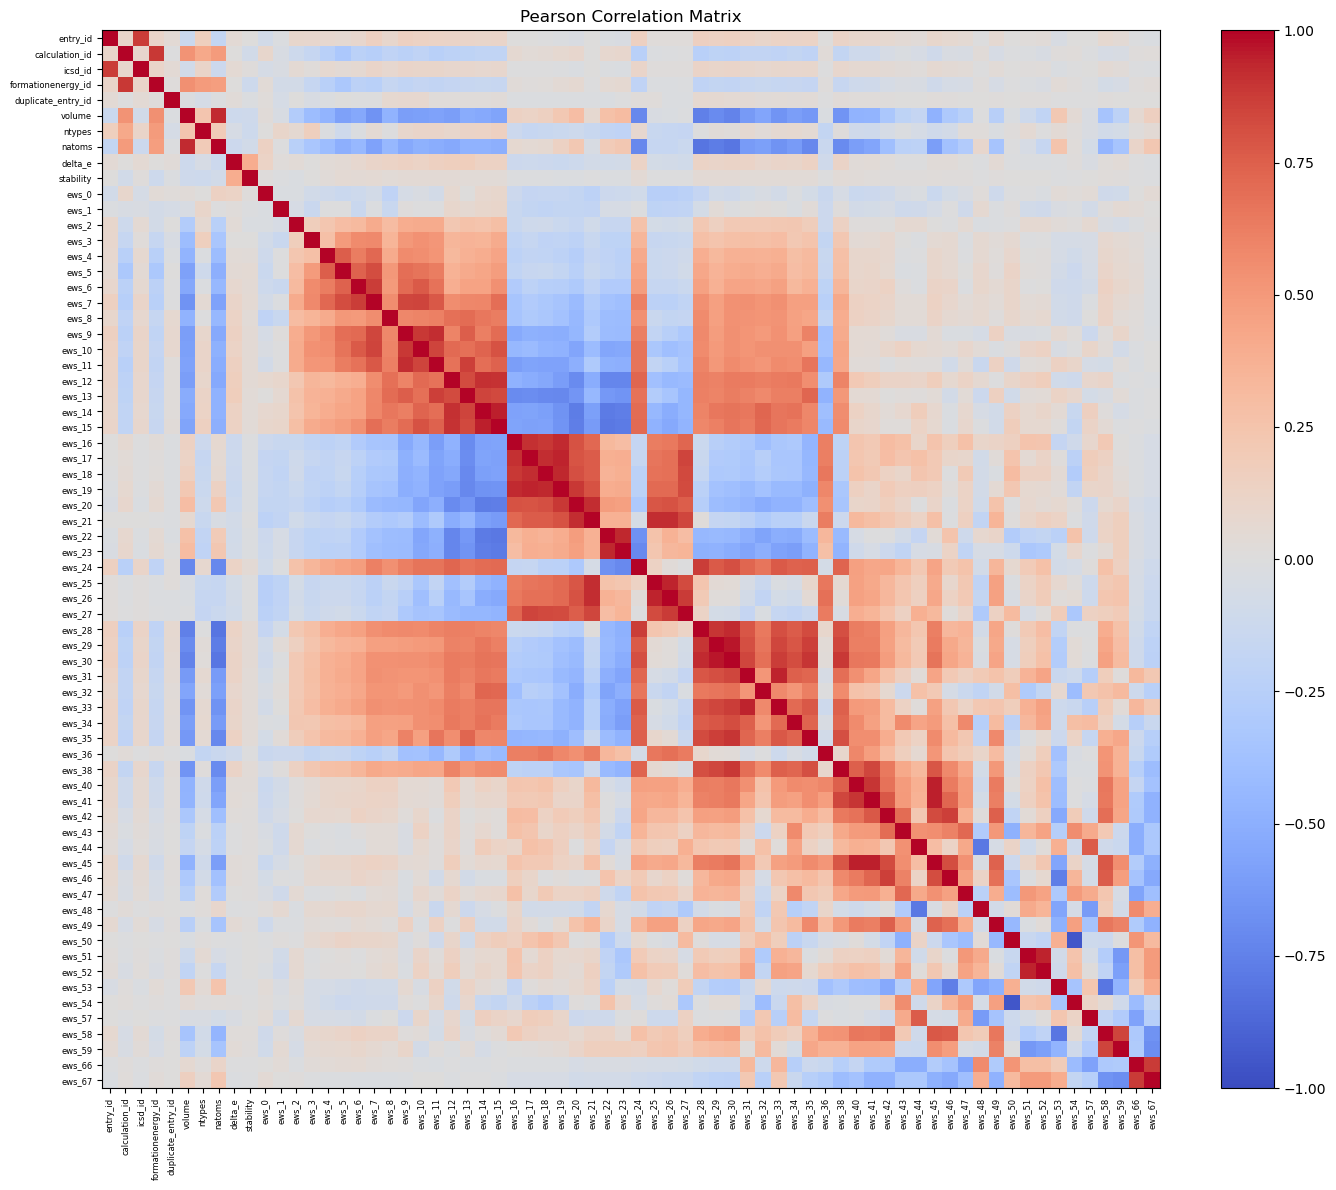

In [133]:
import matplotlib.pyplot as plt

y = df_featurized_ews['band_gap']
X_all_struc = df_featurized_ews.drop(columns=['band_gap', 'structure'])

# Keep only numeric columns
X_all_struc = X_all_struc.select_dtypes(include=[float, int])
print("Number of numeric features before cleaning:", X_all_struc.shape[1])

# Identify columns with very small variance and drop them
small_var_cols_struc = X_all_struc.columns[X_all_struc.var() < 1e-5].tolist()
print("Columns with very small variance:", small_var_cols_struc)
X_all_struc = X_all_struc.drop(columns=small_var_cols_struc)

# Compute correlation matrix
corr_matrix_struc = X_all_struc.corr(method='pearson')
print("Number of features after removing small variance columns:", X_all_struc.shape[1])

# Remove highly correlated columns
threshold = 0.99                    #lowered the threshold as a cheap way of eliminating features, lol
to_drop_struc = set()
for col in corr_matrix_struc.columns:
    high_corr_struc = corr_matrix_struc.index[
        (corr_matrix_struc[col].abs() > threshold) & (corr_matrix_struc.index != col)
    ]
    to_drop_struc.update(high_corr_struc)
print("Columns to drop due to high correlation:", to_drop_struc)
X_struc = X_all_struc.drop(columns=list(to_drop_struc))
print("Number of features after removing highly correlated columns:", X_struc.shape[1])

# Plot correlation matrix
corr_matrix_struc = X_struc.corr(method='pearson')
plt.figure(figsize=(16, 12))
im = plt.imshow(corr_matrix_struc, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title('Pearson Correlation Matrix')
plt.xticks(range(len(corr_matrix_struc.columns)), [str(c) for c in corr_matrix_struc.columns], rotation=90, fontsize=6)
plt.yticks(range(len(corr_matrix_struc.columns)), [str(c) for c in corr_matrix_struc.columns], fontsize=6)
plt.tight_layout()
plt.show()


In [138]:
# SPLIT INTO TRAIN VALIDATION AND TEST
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_struc)

test_fraction = 0.1
validation_fraction = 0.2
X_trainval, X_test, y_trainval, y_test = train_test_split(X_scaled, y, 
                                                          test_size=test_fraction, 
                                                          random_state=17)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, 
                                                  test_size=validation_fraction/(1-test_fraction), 
                                                  random_state=17)
print(f"Training fraction: {X_train.shape[0] / X_scaled.shape[0]:.2f}")
print(f"Validation fraction: {X_val.shape[0] / X_scaled.shape[0]:.2f}")
print(f"Test fraction: {X_test.shape[0] / X_scaled.shape[0]:.2f}")

Training fraction: 0.70
Validation fraction: 0.20
Test fraction: 0.10


In [139]:
from sklearn.metrics import mean_absolute_error

mean_train = y_train.mean()
baseline_mae = mean_absolute_error(y_val, [mean_train] * len(y_val))
print(f"Baseline MAE (predicting density): {baseline_mae:.4f} ")

Baseline MAE (predicting density): 1.3480 


RFE Progress:   0%|          | 0/13 [00:00<?, ?it/s]

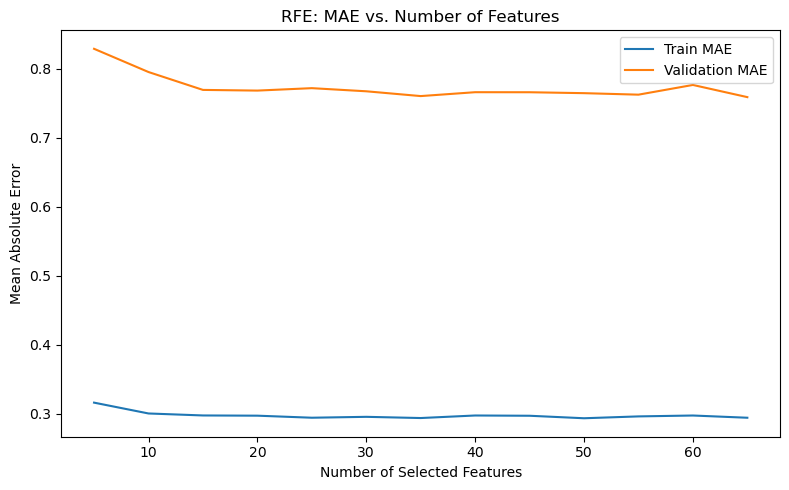

In [141]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_absolute_error
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np

# Use your already scaled and split data:
# X_train, X_val, y_train, y_val

# Because X_train and X_val are numpy arrays (scaled), 
# you need to keep track of feature names separately
feature_names = X_struc.columns  # from your previous cleaning step

rf = RandomForestRegressor(
    n_estimators=500,
    max_depth=20,
    max_features=0.5,
    min_samples_split=2,
    random_state=17,
    n_jobs=1
)

n_features_list = list(range(5, X_val.shape[1]+1, 5))
val_errors = []
train_errors = []
selected_features_dict = {}

for n_features in tqdm(n_features_list, desc='RFE Progress'):
    rfe = RFE(estimator=rf, n_features_to_select=n_features, step=5)
    rfe.fit(X_train, y_train)
    
    selected_features = feature_names[rfe.support_].tolist()
    selected_features_dict[n_features] = selected_features
    
    X_train_rfe = rfe.transform(X_train)
    rf.fit(X_train_rfe, y_train)
    
    y_train_pred = rf.predict(X_train_rfe)
    train_errors.append(mean_absolute_error(y_train, y_train_pred))
    
    X_val_rfe = rfe.transform(X_val)
    y_val_pred = rf.predict(X_val_rfe)
    val_errors.append(mean_absolute_error(y_val, y_val_pred))

plt.figure(figsize=(8, 5))
plt.plot(n_features_list, train_errors, label='Train MAE')
plt.plot(n_features_list, val_errors, label='Validation MAE')
plt.xlabel('Number of Selected Features')
plt.ylabel('Mean Absolute Error')
plt.title('RFE: MAE vs. Number of Features')
plt.legend()
plt.tight_layout()
plt.show()


In [143]:
from sklearn.metrics import r2_score

final_features = selected_features_dict[15]
rf_final = RandomForestRegressor(
    n_estimators=500,
    max_depth=20,
    max_features=0.5,
    min_samples_split=2,
    random_state=1,
    n_jobs=1
)

X_train_final = X_train[:, [X.columns.get_loc(f) for f in final_features]]
rf_final.fit(X_train_final, y_train)

# Predict
X_val_final = X_val[:, [X.columns.get_loc(f) for f in final_features]]
X_test_final = X_test[:, [X.columns.get_loc(f) for f in final_features]]

y_train_pred = rf_final.predict(X_train_final)
y_val_pred = rf_final.predict(X_val_final)
y_test_pred = rf_final.predict(X_test_final)

# Metrics
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_val = mean_absolute_error(y_val, y_val_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

r2_train = r2_score(y_train, y_train_pred)
r2_val = r2_score(y_val, y_val_pred)
r2_test = r2_score(y_test, y_test_pred)

# --- Parity plots (0.1 to 5 range) ---
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)

min_val = 0.0
max_val = 5.0

# Train
axes[0].scatter(y_train, y_train_pred, alpha=0.5, color='blue')
axes[0].plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)
axes[0].set_xlim(min_val, max_val)
axes[0].set_ylim(min_val, max_val)
axes[0].set_title(f"Train (MAE={mae_train:.3f}, R2={r2_train:.3f})")
axes[0].set_xlabel("True Formation Energy")
axes[0].set_ylabel("Predicted Formation Energy")
axes[0].set_aspect('equal', adjustable='box')
axes[0].grid(True, linestyle='--', alpha=0.3)

# Validation
axes[1].scatter(y_val, y_val_pred, alpha=0.5, color='orange')
axes[1].plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)
axes[1].set_xlim(min_val, max_val)
axes[1].set_ylim(min_val, max_val)
axes[1].set_title(f"Validation (MAE={mae_val:.3f}, R2={r2_val:.3f})")
axes[1].set_xlabel("True Formation Energy")
axes[1].set_ylabel("Predicted Formation Energy")
axes[1].set_aspect('equal', adjustable='box')
axes[1].grid(True, linestyle='--', alpha=0.3)

# Test
axes[2].scatter(y_test, y_test_pred, alpha=0.5, color='green')
axes[2].plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)
axes[2].set_xlim(min_val, max_val)
axes[2].set_ylim(min_val, max_val)
axes[2].set_title(f"Test (MAE={mae_test:.3f}, R2={r2_test:.3f})")
axes[2].set_xlabel("True Band Gap (eV)")
axes[2].set_ylabel("Predicted Band Gap (eV)")
axes[2].set_aspect('equal', adjustable='box')
axes[2].grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()


KeyError: 'ews_0'